# Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm as pbar
import torch
import torch.nn as nn
import pickle

from multisensory import ClassicalTask, BalancedComodulationTask, DetectionTask

plt.style.use('./style_sheet.mplstyle')

path = 'C:/Users/ghosh/OneDrive/Desktop/ideal_data'
infile = open(path, 'rb')
ideal_data = pickle.load(infile)
infile.close()

ideal_acc = []
for task in ideal_data.keys():
    ideal_acc.append(ideal_data[task][-1] * 100)


To do:

# Hyperparameters

In [2]:
# Network
nb_inputs = 4
nb_hidden = 2
nb_outputs = 3
repeats = 5
batch_size = 25
positive_weights = False

# Tasks
tasks = [
    ClassicalTask(s=0.1),
    DetectionTask(pm=2 / 3, pe=0.3, pc=0.28, pn=1 / 3, pi=0.01),  # dense
    DetectionTask(pm=2 / 3, pe=0.057, pc=0.95, pn=1 / 3, pi=0.01),  # sparse
    BalancedComodulationTask(s=0.2),
]
task_labels = ["Cl", "Dd", "Ds", "Cm+"]
nb_trials = 10000
nb_steps = 90

# Activation functions
unisensory_activation = lambda x: x * (x > 0)  # relu

multisensory_activations = [
    lambda x, a, b: (x + torch.stack((a, b))[:, None, None]),  # linear + 2 biases
    lambda x, a, b: (x + torch.stack((a, b))[:, None, None])
    * ((x + torch.stack((a, b))[:, None, None]) > 0),  # relu + 2 biases
    lambda x, a, b: torch.sigmoid(
        (x + torch.stack((a, b))[:, None, None])
    ),  # sigmoid + 2 biases
    lambda x, a, b: torch.where(
        (a * x + b) > 20, (a * x + b), torch.log(1 + torch.exp(a * x + b))
    ),  # softplus + 2 trainable parametes + threshold (for n.stability)
]

colors_ma = ["xkcd:muted blue", "xkcd:coral pink", "xkcd:coral pink", "xkcd:coral pink"]
alpha_ma = [1.0, 0.2, 0.6, 1.0]
af_offset = [-0.3, -0.1, 0.1, 0.3]

# Network Functions

In [3]:
def build_input_layer(A, V):
    input_layer = [[] for _ in range(len(A))]
    for trial in range(len(A)):
        audio_left = unisensory_activation(-A[trial])
        audio_right = unisensory_activation(A[trial])

        video_left = unisensory_activation(-V[trial])
        video_right = unisensory_activation(V[trial])

        input_layer[trial] = torch.from_numpy(
            1 * np.vstack([audio_left, audio_right, video_left, video_right])
        )  # input units x time

    return input_layer


In [4]:
def check_choice(multisensory_activation, W0, W1, a_param, b_param, A, V, y_data):
    input_layer = build_input_layer(A, V)
    y = torch.stack(
        input_layer, axis=2
    ).float()  # input units x time steps x batch_size

    multisensory_layer = multisensory_activation(
        torch.einsum("ij, jkl -> ikl", W0, y), a_param, b_param
    )  # hidden units x time steps x batch_size
    decision_layer = torch.sum(
        torch.einsum("mi, ikl -> mkl", W1, multisensory_layer), axis=1
    )  # output units x batch_size
    decision_layer = decision_layer + (
        torch.randn(*decision_layer.shape) / 1000
    )  # output units x batch_size

    x = torch.argmax(decision_layer, axis=0)

    return x, decision_layer, 100 * (((x == y_data) * 1.0).sum() / len(x))

In [5]:
def check_accuracy_over_time(
    multisensory_activation, W0, W1, a_param, b_param, A, V, y_data
):
    input_layer = build_input_layer(A, V)
    y = torch.stack(
        input_layer, axis=2
    ).float()  # input units x time steps x batch_size

    multisensory_layer = multisensory_activation(
        torch.einsum("ij,jkl -> ikl", W0, y), a_param, b_param
    )  # hidden units x time steps x batch_size
    decision_layer = torch.einsum(
        "mi, ikl -> mkl", W1, multisensory_layer
    )  # output units x time steps x batch_size
    decision_layer = decision_layer + (
        torch.randn(*decision_layer.shape) / 1000
    )  # output units x time steps x batch_size
    decision_layer = torch.cumsum(
        decision_layer, dim=1
    )  # output units x time steps x batch_size

    x = (
        torch.argmax(decision_layer, axis=0) == y_data[None, :]
    ) * 1.0  # time steps x batch_size

    return np.array(x)

In [6]:
def batch_generator(A, V, y_data, batch_size):
    # Shuffle
    perm = torch.randperm(A.shape[0])
    A_shuffled = A[perm]
    V_shuffled = V[perm]
    y_data_shuffled = y_data[perm]

    # Batches
    n_batch = len(perm) // batch_size

    for i in range(n_batch):
        A_local = A_shuffled[(i * batch_size) : (i + 1) * batch_size]
        V_local = V_shuffled[(i * batch_size) : (i + 1) * batch_size]
        y_local = y_data_shuffled[(i * batch_size) : (i + 1) * batch_size]

        yield A_local, V_local, y_local

In [7]:
def train(
    multisensory_activation,
    W0,
    W1,
    a_param,
    b_param,
    A,
    V,
    y_data,
    batch_size,
    nb_epochs=10,
    lr=0.001,
    positive_weights=False,
):
    optimizer = torch.optim.Adam([W0, W1, a_param, b_param], lr=lr)
    log_softmax_fn = nn.LogSoftmax(dim=0)
    loss_fn = nn.NLLLoss()  # weighted negative log likelihood loss

    loss_hist = []
    for e in range(nb_epochs):
        local_loss = []
        for A_local, V_local, y_local in batch_generator(A, V, y_data, batch_size):
            # Run network
            _, output, _ = check_choice(
                multisensory_activation,
                W0,
                W1,
                a_param,
                b_param,
                A_local,
                V_local,
                y_local,
            )

            # Compute loss
            loss = loss_fn(log_softmax_fn(output).T, y_local.long())
            local_loss.append(loss.item())

            # Update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Constrain weights
            if positive_weights:
                # W0.data = W0.clamp(min=0)
                # W1.data = W1.clamp(min=0)

                W0.data = torch.abs(W0.data)
                W1.data = torch.abs(W1.data)

        loss_hist.append(np.mean(local_loss))

    return loss_hist

# Analysis

In [8]:
# Train networks
y_list, y_list_class, rt_list, W0_list, W1_list, af_list, task_list, ma_list = (
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
)

for t, task in enumerate(pbar(tasks)):
    # Generate data
    trials = task.generate_trials(nb_trials, nb_steps)
    y_train, A_train, V_train = torch.tensor(trials.M + 1), trials.A, trials.V

    trials = task.generate_trials(nb_trials, nb_steps)
    y_test, A_test, V_test = torch.tensor(trials.M + 1), trials.A, trials.V

    for b, multisensory_activation in enumerate(multisensory_activations):
        for c in range(repeats):
            # Weights
            W0 = nn.Parameter(torch.empty((nb_hidden, nb_inputs)), requires_grad=True)
            W1 = nn.Parameter(torch.empty((nb_outputs, nb_hidden)), requires_grad=True)
            nn.init.uniform_(W0, 0.0, 1.0)
            nn.init.uniform_(W1, 0.0, 1.0)

            # Parameters
            a_param = nn.Parameter(torch.tensor(1.0), requires_grad=True)
            b_param = nn.Parameter(torch.tensor(1.0), requires_grad=True)

            loss_hist = train(
                multisensory_activation,
                W0,
                W1,
                a_param,
                b_param,
                A_train,
                V_train,
                y_train,
                batch_size,
                nb_epochs=250,
                lr=0.005,
                positive_weights=positive_weights,
            )
            x, _, y = check_choice(
                multisensory_activation,
                W0,
                W1,
                a_param,
                b_param,
                A_test,
                V_test,
                y_test,
            )
            rt = check_accuracy_over_time(
                multisensory_activation,
                W0,
                W1,
                a_param,
                b_param,
                A_test,
                V_test,
                y_test,
            )

            y_list.append(y)
            y_list_class.append(
                [
                    ((x == d) & (y_test == d)).sum().float()
                    / (y_test == d).sum().float()
                    for d in range(nb_outputs)
                ]
            )
            rt_list.append(rt)
            W0_list.append(W0.detach().numpy())
            W1_list.append(W1.detach().numpy())
            af_list.append([a_param.item(), b_param.item()])
            task_list.append(t)
            ma_list.append(b)

100%|██████████| 4/4 [2:35:13<00:00, 2328.35s/it]  


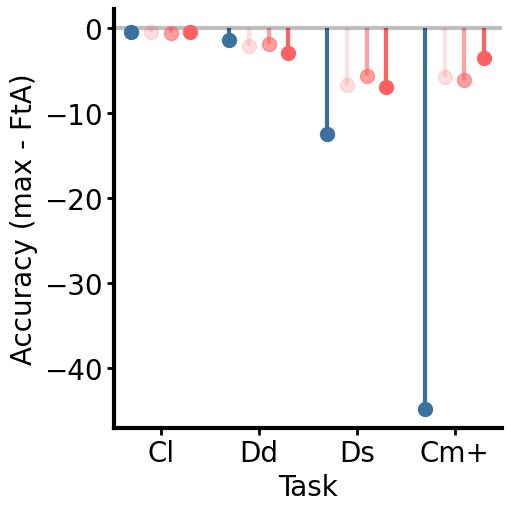

In [9]:
plt.subplots(constrained_layout=True)
plt.axhline(0, ls="-", c="k", alpha=0.25)

for af, _ in enumerate(multisensory_activations):
    y = [
        np.max(np.array(y_list)[(np.array(ma_list) == af) & (np.array(task_list) == t)])
        for t in range(len(tasks))
    ]

    ml, sl, bl = plt.stem(
        np.arange(0, len(tasks)) + af_offset[af],
        np.array(y) - np.array(ideal_acc),
    )
    bl.set_alpha(0)
    ml.set_color(colors_ma[af]), ml.set_alpha(alpha_ma[af])
    sl.set_color(colors_ma[af]), sl.set_alpha(alpha_ma[af])

plt.xticks(range(len(tasks)), task_labels)
plt.xlabel("Task")
plt.ylabel("Accuracy (max - FtA)")
plt.savefig("AF_comp_0.svg")

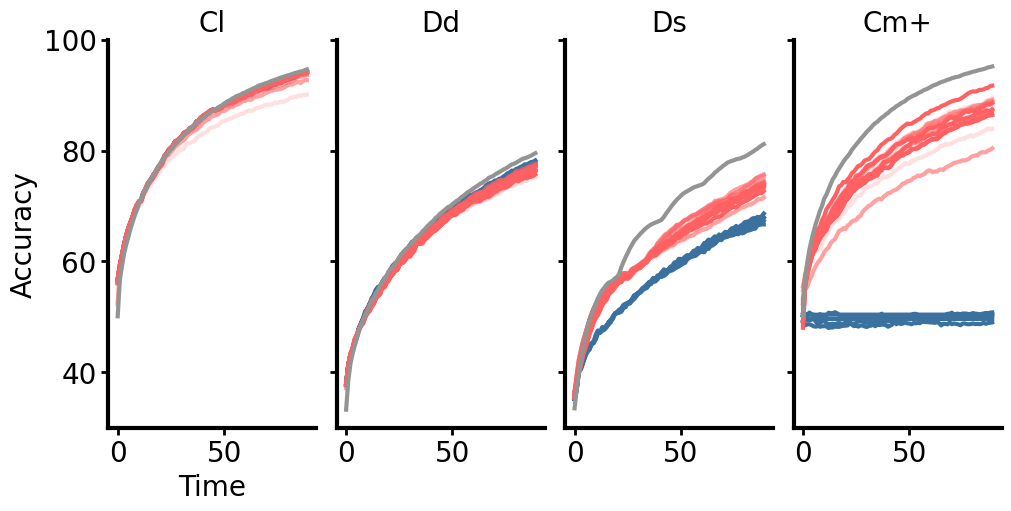

In [10]:
# Plot reaction times
fig, ax = plt.subplots(
    1, len(tasks), figsize=(10, 5), sharex=True, sharey=True, constrained_layout=True
)

for network in range(len(rt_list)):
    plt.sca(ax[task_list[network]])
    plt.plot(
        np.mean(100 * rt_list[network], axis=1),
        color=colors_ma[ma_list[network]],
        alpha=alpha_ma[ma_list[network]],
    )

plt.sca(ax[0])
plt.xlabel("Time")
plt.ylim([30, 100])
plt.ylabel("Accuracy")

for t, task in enumerate(ideal_data.keys()):
    plt.sca(ax[t])
    plt.plot(np.array(ideal_data[task]) * 100, color="xkcd:gray")
    plt.title(task_labels[t])

plt.savefig("AF_comp_1.svg")